# ASSET demonstration

This notebook aims at showing how to use the ASSET package to extract a spectrum
from log-slit spectroscopy data. This example generates a toy model and then extract the spectrum with several types of PSF.

## Install and load required packages
---

In [ ]:
# Install packages to run ASSET
# using Pkg
# pkg"registry add https://github.com/emmt/EmmtRegistry"
# pkg"add https://github.com/SJJThe/InverseProblem"
# pkg"add https://github.com/SlitSpectroscopyBuddies/ASSET.git"

# Install packages for the demo
# pkg"add DelimitedFiles"
# pkg"add PyPlot"

In [11]:
# Load packages
using DelimitedFiles
using PyPlot
using InterpolationKernels
using LinearInterpolators
using InverseProblem

using ASSET

## Generation of a Toy Model
---

The following cells generate a Toy Model to present how to use ASSET.
The spectrum used in the Toy Model was obtained from the P330 E CALSPEC reference spectrum (Bohlin, Gordon & Tremblay 2014). We use a version of this spectrum sampled with 1024 points between 0.5 and 10 microns.
The PSF used in the Toy Model was obtained from the P330 E MIRI LRS data (see Figure 3. and 4. of the paper). We used the two-order non-parametric PSF.
We generate some spatial and spectral coordinate maps align on the grid.

In [ ]:
# Interpolation kernel 
ker = CatmullRomSpline(Float64, Flat)

# Get the Toy Model spectrum
lz = readdlm("p330e_for_toymodel.txt");
lz = lz[(lz[:,1].>=4).&&(lz[:,1].<=9),:]
l_tm=lz[:,1]
z_tm=lz[:,2]
λmin=l_tm[1]
λmax=l_tm[end]

Nz=length(z_tm)
# Get the Toy Model PSF and its data
hx=readdlm("nonparametric_parameters_at_order_2.txt")
coord_tm=hx[:,1]
psf_tm=hx[:,2:end]
shift2=0.7728 # generate an arbitrary shift of the PSF
l_ref = 14.0018 #reference wevelength
order=size(psf_tm)[2]
psf_size=size(psf_tm)[1]

# Generate an arbitrary regularization for the PSF structure
hph=1e0
wh=cat(ones(psf_size,order),zeros(psf_size,order),dims=3)
Rh=WeightedTikhonov(hph, wh);

# Generate a non-parametric PSF of order 2 from the PSF saved 
h_tm=ASSET.SeriesExpansionPSF(psf_tm,range(coord_tm[1],stop=coord_tm[end],length=length(coord_tm)), shift2,ker ,Rh)

SeriesExpansionPSF{Float64, Matrix{Float64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, CatmullRomSpline{Float64, Flat}, WeightedTikhonov{Float64}}([0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], -115.0:1.0:115.0, 0.7728, CatmullRomSpline{Float64, Flat}(), Weighted Tikhonov:
 - level `mu` : 1.0
 - weights` : [1.0 1.0; 1.0 1.0; … ; 1.0 1.0; 1.0 1.0;;; 0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0])

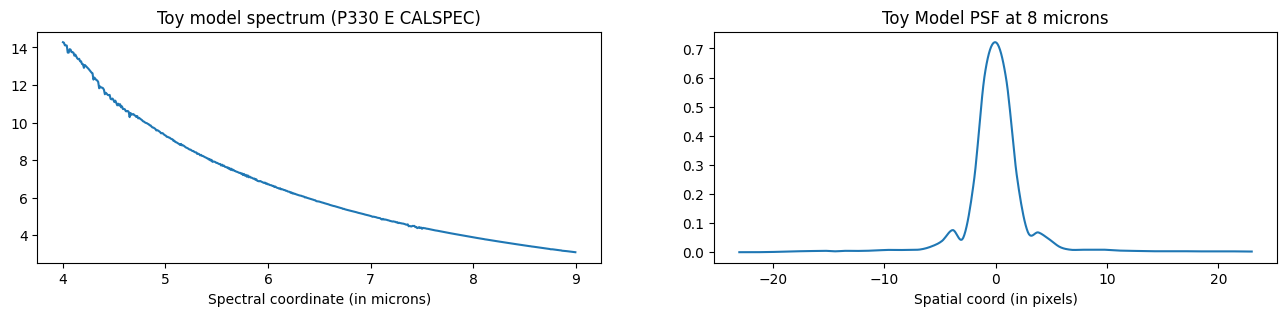

PyObject Text(0.5, 23.999999999999993, 'Spatial coord (in pixels)')

In [16]:
xx=collect(-23:0.1:23)

fig, axs = PyPlot.subplots(1,2)
fig.set_size_inches(w=16, h=3)
axs[1].set_title("Toy model spectrum (P330 E CALSPEC)")
axs[1].plot(l_tm,z_tm)
axs[1].set_xlabel("Spectral coordinate (in microns)")
axs[2].set_title("Toy Model PSF at 8 microns")
axs[2].plot(xx, h_tm(xx,8. *ones(length(xx)), λref=λmax)*h_tm[:])
axs[2].set_xlabel("Spatial coord (in pixels)")

In [4]:
m = 840 # Number of columns in the data
n = 42  # Number of rows in the data
lambda = repeat(collect(range(λmin, stop=λmax, length=m))', outer=(n,1,2)) # generate a spectral map for two dithers
rho = cat(repeat(collect(range(-n/3, step=1, length=n)), outer=(1,m)),
          repeat(collect(range(-2*n/3, step=1, length=n)), outer=(1,m)), dims=3) #generate spatial map for two dithers


λz=range(λmin, length=Nz, stop=λmax); #Sampling for the spectrum extraction
F = SparseInterpolator(ker, lambda, λz) #Interpolator for the spectrum

H=zeros(n,m,2)
psf_map!(H, h_tm, rho, lambda)
H ./= sum(H,dims=1)
tm=H.*(F*z_tm) .+1e-3

data = tm .+ sqrt.(abs.(tm) .+ 1e-6).*randn(n,m,2) #Generate some data with i.i.d photon noise and some readout noise of var 1e-6
wgt = (rand(n,m,1) .< 0.9)./(abs.(tm) .+ 1e-6) #Generate some weiths as the inverse of the diagonal covariance of the data and with some defective pixels

D = CalibratedData(data, wgt, rho, lambda);

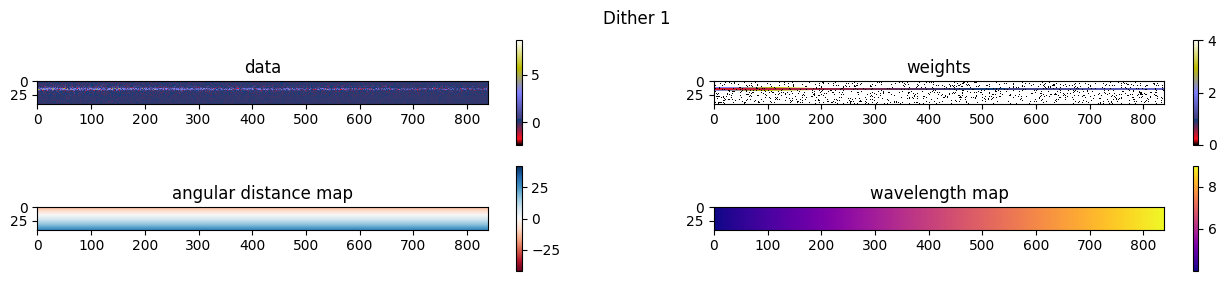

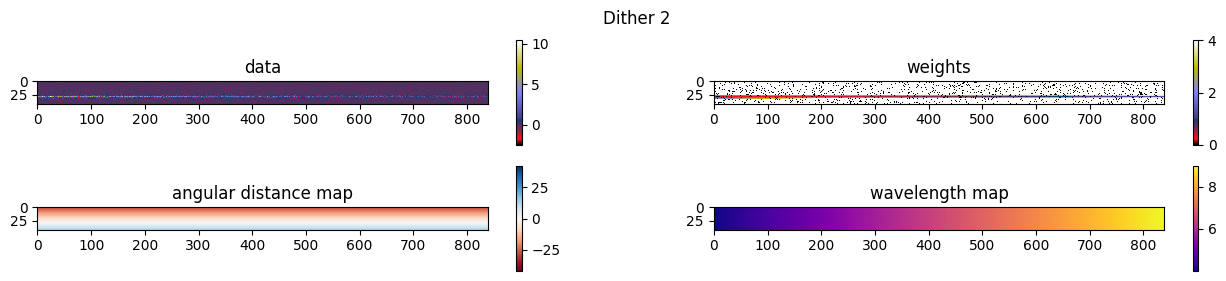

PyObject <matplotlib.colorbar.Colorbar object at 0x759d084f5370>

In [26]:
frame = 1
fig, axs = plt.subplots(2,2)
fig.suptitle("Dither $(frame)")
fig.set_size_inches(w=16, h=3)
axs[1,1].set_title("data")
im1 = axs[1,1].imshow(D.d[:,:,frame],cmap="gist_stern", interpolation="none")
fig.colorbar(im1)
axs[1,2].set_title("weights")
im2 = axs[1,2].imshow(D.w[:,:,frame],  cmap="gist_stern", interpolation="none", vmax=4)
fig.colorbar(im2)
axs[2,1].set_title("angular distance map")
im3 = axs[2,1].imshow(D.ρ_map[:,:,frame], cmap="RdBu",vmin=-n, vmax=n)
fig.colorbar(im3)
axs[2,2].set_title("wavelength map")
im4 = axs[2,2].imshow(D.λ_map[:,:,frame],cmap="plasma")
fig.colorbar(im4)

frame = 2
fig, axs = plt.subplots(2,2)
fig.suptitle("Dither $(frame)")
fig.set_size_inches(w=16, h=3)
axs[1,1].set_title("data")
im1 = axs[1,1].imshow(D.d[:,:,frame],cmap="gist_stern", interpolation="none")
fig.colorbar(im1)
axs[1,2].set_title("weights")
im2 = axs[1,2].imshow(D.w[:,:,frame],  cmap="gist_stern", interpolation="none", vmax=4)
fig.colorbar(im2)
axs[2,1].set_title("angular distance map")
im3 = axs[2,1].imshow(D.ρ_map[:,:,frame], cmap="RdBu",vmin=-n, vmax=n)
fig.colorbar(im3)
axs[2,2].set_title("wavelength map")
im4 = axs[2,2].imshow(D.λ_map[:,:,frame],cmap="plasma")
fig.colorbar(im4)

## Extractions examples
---

In [ ]:
hpz=5e1 #regularization parameter for the spectrum
hpb=1e3  #regularization parameter for the background (reaaaally high because we know it's a scalar background)
Rz=WeightedTikhonov(hpz, ones(Nz,1)) #Spectrum regularization
Rb=hpb*tikhonov() #Background regularization

b=ASSET.BkgMdl(zeros(n,m), Rb) #Background model

BkgMdl{Float64, 2, @NamedTuple{lower::Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], HomogenRegul:
 - level `mu` : 1000.0
 - function `func` : InverseProblem.Tikhonov()
 - use direct inversion `direct_inversion` : true
 - degree `deg` : 2.0, (lower = 0.0,))

### Parametric models


#### Chromatic Gaussian

In [7]:
parinit = maximum(lambda)^(-2)
psf_params_bnds=[(1e-8, 1.)] #The bounds of the gaussian psf parameter for the autocalibration
center_bnds=1. #The bounds of the gaussian center for the autocalibration
h_pg=ASSET.chromGaussianPSF(parinit)
z_pg=zeros(Nz); 

z_fpg,h_fpg =ASSET.extract_spectrum!(z_pg, F, h_pg, D, Rz, undef;
                                    auto_calib=Val(true),
                                    max_iter=100,
                                    extract_kwds=(psf_params_bnds=psf_params_bnds,
                                                  psf_center_bnd=center_bnds,
                                                  max_iter=100));

LoadError: StackOverflowError:

#### Chromatic Moffat

In [ ]:
parinit = [h_pg.a, 2.]
psf_params_bnds=[(0., 3.);(1., 3.)]
center_bnds=2.
h_pm=ASSET.chromMoffatPSF(parinit)
z_pm=zeros(Nz)

z_fpm,h_fpm =ASSET.extract_spectrum!(z_pm, F, h_pm, D ,Rz, b;
                                    auto_calib=Val(true),
                                    max_iter=100,
                                    extract_kwds=(psf_params_bnds=psf_params_bnds, 
                                                    psf_center_bnd=center_bnds,
                                                    max_iter=100));

### Non-Parametric PSF

#### Series expansion PSF with one order

In [ ]:
order=1

shift_bnds=(-1.,1.)
center_bnds=2.

# Defining the coordinate of the PSF reference plane
gamma=maximum(lambda)./lambda
gamma[lambda .==0] .= 0.
xmin=floor(minimum(gamma.*rho))
xmax=ceil(maximum(gamma.*rho))
x = range(min(xmin,-xmax), 
          stop=max(xmax,-xmin), 
          step=1.)
          
psf_size=length(x)
hph=1e0
wh=cat(ones(psf_size,order),zeros(psf_size,order),dims=3)
Rh=WeightedTikhonov(hph, wh);

h_se1=ASSET.SeriesExpansionPSF(zeros(psf_size,order),x, 0.0,ker ,Rh)

z_se1=copy(z_pm) #initiliaze spectrum with an approximation of the solution to avoid local minima

z_fse1,h_fse1 =ASSET.extract_spectrum!(z_se1, F, h_se1, D ,Rz, b;
            auto_calib=Val(true),
            max_iter=100,
            extract_kwds=(psf_center_bnd=center_bnds,
                          psf_shift_bnds=shift_bnds,
                          max_iter=10));

#Normalization by the PSF area                          
dx=0.1
xx=collect(-23.:dx:23.);
for (i,λk) in enumerate(λz)
    λλ=λk*ones(length(xx))
    HNP = h_fse1(xx,λλ,λref=maximum(lambda))*h_fse1[:]
    z_fse1[i] = z_se1[i]*sum(HNP)*dx
end
  
         

#### Series expansion PSF with two orders

In [ ]:
order=2

shift_bnds=(-1.,1.)
center_bnds=2.

hph=1e0
wh=cat(ones(psf_size,order),zeros(psf_size,order),dims=3)
Rh=WeightedTikhonov(hph, wh);

hnpo=ASSET.SeriesExpansionPSF(zeros(psf_size,order),x, 0.0,ker ,Rh)

z_se2=copy(z_pm) #initiliaze spectrum with an approximation of the solution to avoid local minima

z_fse2,h_fse2=ASSET.extract_spectrum!(z_se2, F, h_se2, D ,Rz, b;
            auto_calib=Val(true),
            max_iter=100,
            extract_kwds=(psf_center_bnd=center_bnds,
                          psf_shift_bnds=shift_bnds,
                          max_iter=10));

#Normalization by the PSF area                          
dx=0.1
xx=collect(-23.:dx:23.);
for (i,λk) in enumerate(λz)
    λλ=λk*ones(length(xx))
    HNP = h_fse2(xx,λλ,λref=maximum(lambda))*h_fse2[:]
    z_fse2[i] = z_se2[i]*sum(HNP)*dx
end
  

## Results
---


In [8]:
using PyPlot
const plt = PyPlot

PyPlot

### Data

Plotting the first frame of the `CalibratedData` structure:

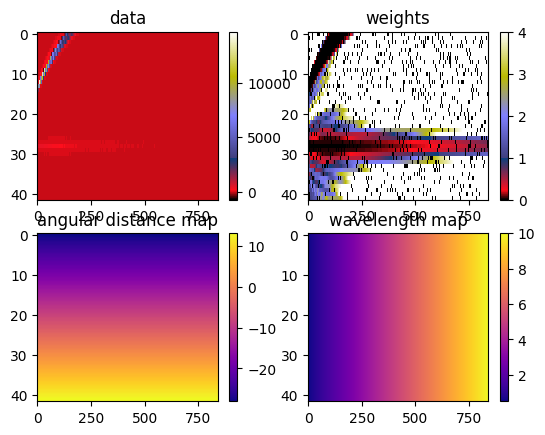

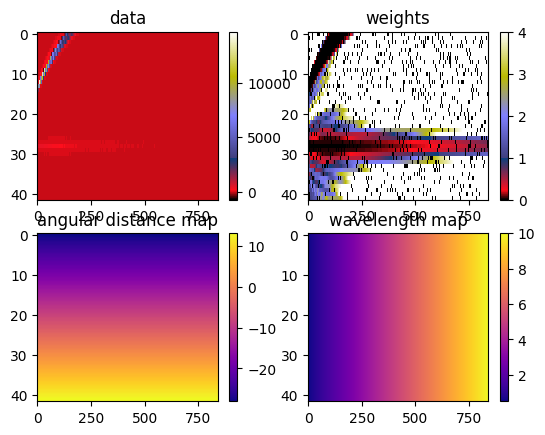

In [ ]:
frame = 2
fig, axs = plt.subplots(2,2)
axs[1,1].set_title("data")
im1 = axs[1,1].imshow(D.d[:,:,frame], aspect="auto", cmap="gist_stern", interpolation="none")
fig.colorbar(im1)
axs[1,2].set_title("weights")
im2 = axs[1,2].imshow(D.w[:,:,frame], aspect="auto", cmap="gist_stern", interpolation="none", vmax=4)
fig.colorbar(im2)
axs[2,1].set_title("angular distance map")
im3 = axs[2,1].imshow(D.ρ_map[:,:,frame], aspect="auto", cmap="plasma")
fig.colorbar(im3)
axs[2,2].set_title("wavelength map")
im4 = axs[2,2].imshow(D.λ_map[:,:,frame], aspect="auto", cmap="plasma")
fig.colorbar(im4)
display(gcf())

### PSF models

In [ ]:
h_tm(rho[:,:,1],lambda[:,:,1])

In [ ]:
fig, axs = plt.subplots(1,2)#FIXME: plot the psfs for different wavelengths
axs[1].plot(h_fpg.(rho[:,1,1],lambda[:,1,1]))
axs[1].plot(h_fpm.(rho[:,1,1],lambda[:,1,1]))
axs[1].plot(h_fse1(rho[:,:,1],lambda[:,:,1])*h_fse1[:,1,1])
axs[1].plot(h_fse2(rho[:,:,1],lambda[:,:,1])*h_fse2[:,1,1])
axs[1].plot(h_tm(rho[:,:,1],lambda[:,:,1])*h_tm[:,1,1], color="black", label="ground truth")
axs[1].legend()
display(gcf())

### SED

In [ ]:
fig, axs = plt.subplots()
axs.plot(λz, z_fpg, label="chromatic gaussian")
axs.plot(λz, z_fpm, label="chromatic moffat")
axs.plot(λz, z_fse1, label="series exp. order 1")
axs.plot(λz, z_fse2, label="series exp. order 2")
axs.plot(λz, z_tm, color="black", label="ground truth")
axs.set_ylim(0., 90.)
axs.legend()
display(gcf())